# 📚 Stacking Ensemble Demo on Noisy Synthetic Data

This notebook demonstrates how individual **simple models** struggle with noisy, non-linear synthetic data — and how a **stacking ensemble** can combine their strengths to perform better.

**Classifiers:**
1. **Naive Bayes (NB)** - assumes features don’t affect each other
  - Works well when features are mostly uncorrelated, but fails when dependencies matter.
2. **Logistic Regression (LR)** - draws straight lines between classes
  - Great when classes are linearly separable, but struggles with curves, overlaps, or messy data.
3. **Decision Tree (DT)** - tries to split the data by asking yes/no questions
  -  If it's too shallow, it misses patterns (underfitting); too deep, and it memorizes noise (overfitting).


**Stacking** - lets multiple types of learners combine strengths, meta-learner: LR

**Synth dataset docs**: https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html

## 📥 Load and inspect data

In [27]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score, StratifiedKFold
import seaborn as sns
import itertools


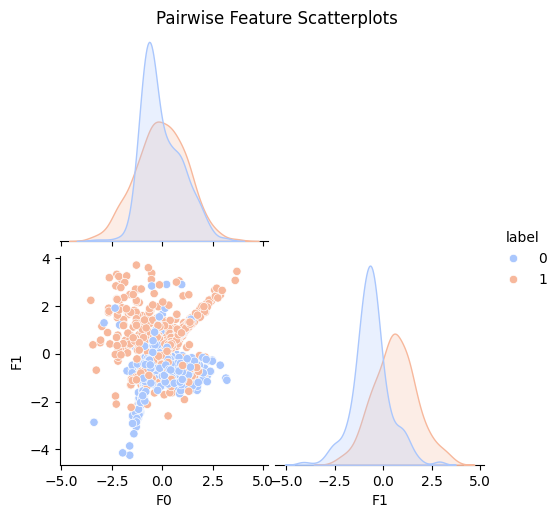

In [8]:
# Generate & visualize synthetic noisy classification dataset
X, y = make_classification(n_samples=1000, n_features=2, n_informative=2,
                           n_redundant=0, flip_y=0.2, class_sep=0.7, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# DataFrame for plotting
df = pd.DataFrame(X, columns=[f"F{i}" for i in range(X.shape[1])])
df["label"] = y

sns.pairplot(df, hue="label", corner=True, palette="coolwarm")
plt.suptitle("Pairwise Feature Scatterplots", y=1.02)
plt.show()

## 🧮 Comparison: simple learners vs STACKING

In [9]:
def evaluate_model_cv(name, model, X, y):
    scores = cross_val_score(model, X, y, cv=cv, scoring='accuracy')
    print(f"{name:20s} Mean Acc: {scores.mean():.3f} | Std: {scores.std():.3f}")
    return scores

In [13]:
models = {
    "Naive Bayes": GaussianNB(),
    "Logistic Regression": LogisticRegression(),
    "Decision Tree": DecisionTreeClassifier(max_depth=5, random_state=42)
}

estimators = [(name.lower().replace(' ', '_'), model) for name, model in models.items()]
final_estimator = LogisticRegression()
stack = StackingClassifier(estimators=estimators, final_estimator=final_estimator, cv=5)
stack




StackingClassifier(cv=5,
                   estimators=[('naive_bayes', GaussianNB()),
                               ('logistic_regression', LogisticRegression()),
                               ('decision_tree',
                                DecisionTreeClassifier(max_depth=5,
                                                       random_state=42))],
                   final_estimator=LogisticRegression())

Naive Bayes          Mean Acc: 0.740 | Std: 0.024
Logistic Regression  Mean Acc: 0.755 | Std: 0.031
Decision Tree        Mean Acc: 0.775 | Std: 0.038
Stacking             Mean Acc: 0.779 | Std: 0.033


<ipython-input-25-c7c61e6a3243>:12: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(cv_results.values(), labels=cv_results.keys(), showmeans=True)


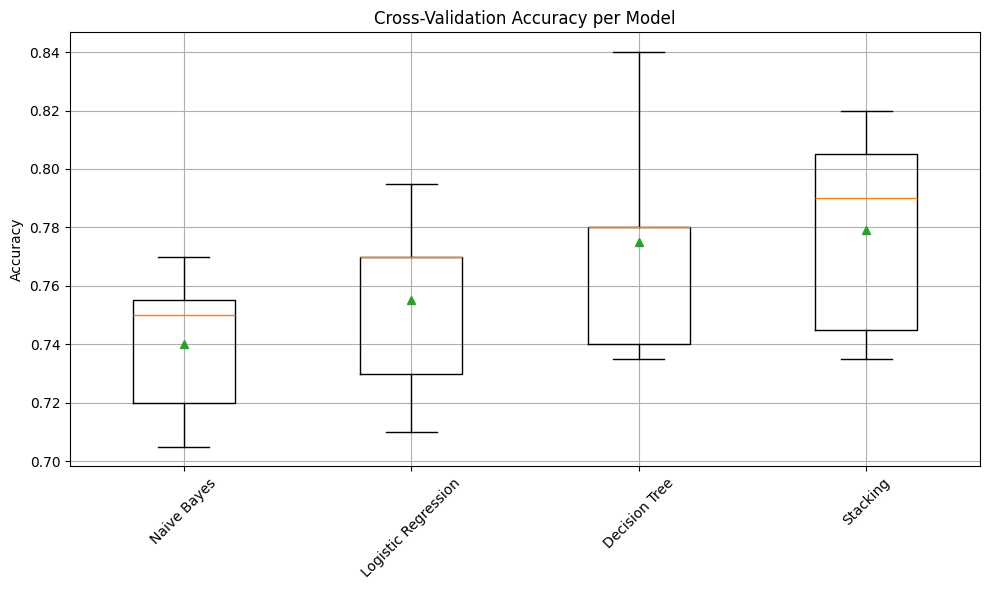

Classification Report - Naive Bayes:

              precision    recall  f1-score   support

     Class 0       0.71      0.76      0.73       153
     Class 1       0.73      0.68      0.70       147

    accuracy                           0.72       300
   macro avg       0.72      0.72      0.72       300
weighted avg       0.72      0.72      0.72       300



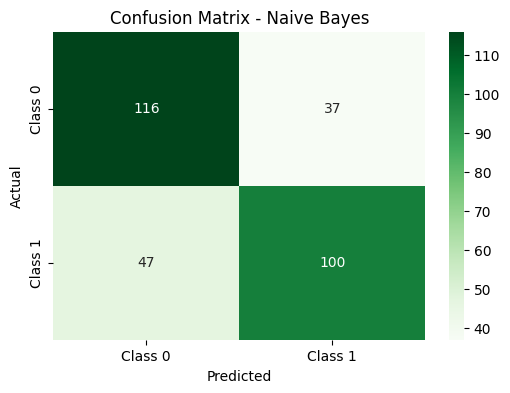

Classification Report - Logistic Regression:

              precision    recall  f1-score   support

     Class 0       0.76      0.74      0.75       153
     Class 1       0.74      0.76      0.74       147

    accuracy                           0.75       300
   macro avg       0.75      0.75      0.75       300
weighted avg       0.75      0.75      0.75       300



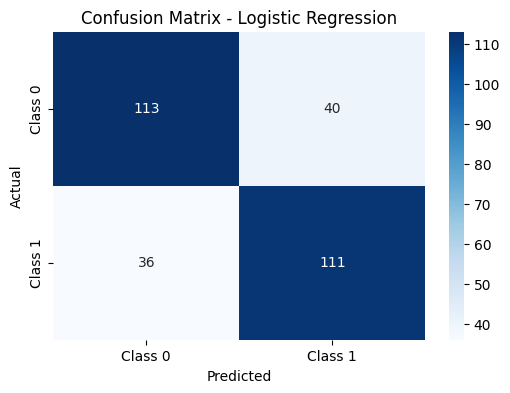

Classification Report - Decision Tree:

              precision    recall  f1-score   support

     Class 0       0.78      0.81      0.79       153
     Class 1       0.79      0.76      0.77       147

    accuracy                           0.78       300
   macro avg       0.78      0.78      0.78       300
weighted avg       0.78      0.78      0.78       300



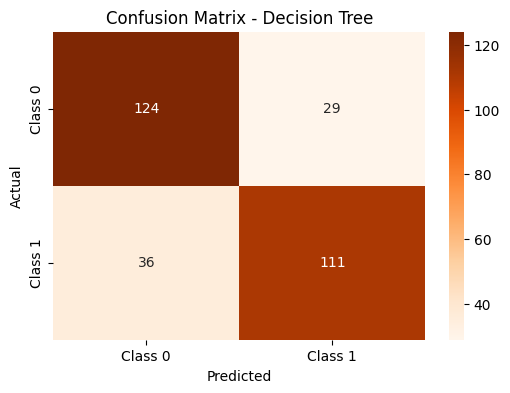

Classification Report - Stacking:

              precision    recall  f1-score   support

     Class 0       0.80      0.82      0.81       153
     Class 1       0.80      0.78      0.79       147

    accuracy                           0.80       300
   macro avg       0.80      0.80      0.80       300
weighted avg       0.80      0.80      0.80       300



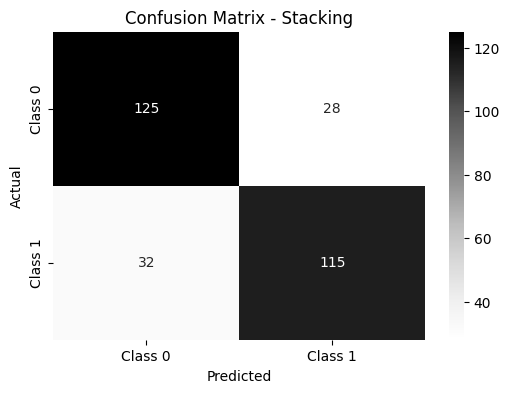

In [25]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_results = {}

for name, model in models.items():
    scores = evaluate_model_cv(name, model, X, y)
    cv_results[name] = scores

stack_scores = evaluate_model_cv("Stacking", stack, X, y)
cv_results["Stacking"] = stack_scores

plt.figure(figsize=(10, 6))
plt.boxplot(cv_results.values(), labels=cv_results.keys(), showmeans=True)
plt.title("Cross-Validation Accuracy per Model")
plt.ylabel("Accuracy")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

class_names = [f"Class {i}" for i in np.unique(y)]

# re-fit & predict
color_maps = ["Greens", "Blues", "Oranges"]

for i, (name, model) in enumerate(models.items()):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"Classification Report - {name}:\n")
    print(classification_report(y_test, y_pred, target_names=class_names))
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6,4))
    cmap = color_maps[i % len(color_maps)]
    sns.heatmap(cm, annot=True, cmap=cmap, xticklabels=class_names, yticklabels=class_names, fmt='d')
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix - {name}")
    plt.show()


stack.fit(X_train, y_train)
y_pred = stack.predict(X_test)

print("Classification Report - Stacking:\n")
print(classification_report(y_test, y_pred, target_names=class_names))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, cmap="Greys", xticklabels=class_names, yticklabels=class_names, fmt='d')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Stacking")
plt.show()



##  
## 📊 Visualization
##  
- Decision boundaries

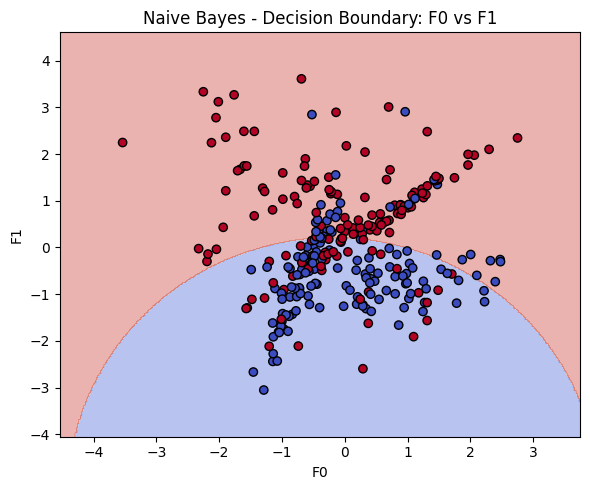

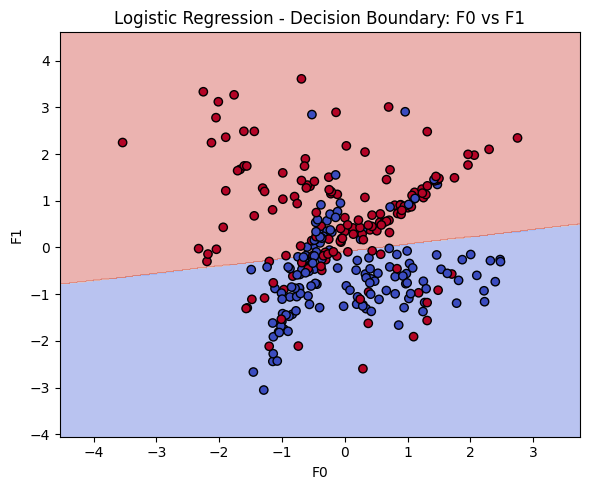

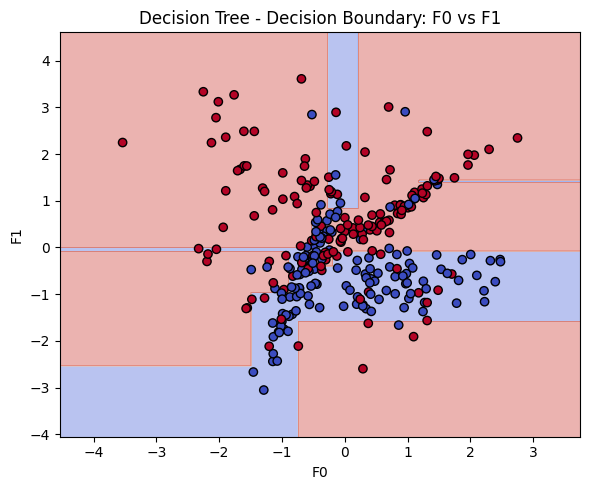

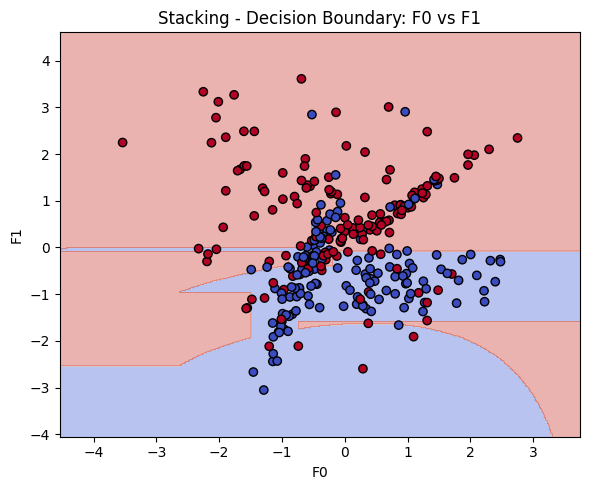

In [29]:
def plot_decision_boundaries_for_pairs(model, X, y, title, feature_names=None, fixed_vals=None ):
    n_features = X.shape[1]
    pairs = list(itertools.combinations(range(n_features), 2))

    if feature_names is None:
        feature_names = [f"F{i}" for i in range(n_features)]

    if fixed_vals is None:
        fixed_vals = X.mean(axis=0)

    for f1, f2 in pairs:
        h = .02
        x_min, x_max = X[:, f1].min() - 1, X[:, f1].max() + 1
        y_min, y_max = X[:, f2].min() - 1, X[:, f2].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                             np.arange(y_min, y_max, h))

        # Build full input with fixed features
        X_grid = np.tile(fixed_vals, (xx.ravel().shape[0], 1))
        X_grid[:, f1] = xx.ravel()
        X_grid[:, f2] = yy.ravel()
        Z = model.predict(X_grid).reshape(xx.shape)
        plt.figure(figsize=(6, 5))
        plt.contourf(xx, yy, Z, alpha=0.4, cmap='coolwarm')
        plt.scatter(X[:, f1], X[:, f2], c=y, cmap='coolwarm', edgecolor='k')
        plt.xlabel(feature_names[f1])
        plt.ylabel(feature_names[f2])
        plt.title(f"{title}: {feature_names[f1]} vs {feature_names[f2]}")
        plt.tight_layout()
        plt.show()



for name, model in models.items():
    plot_decision_boundaries_for_pairs(model, X_test, y_test, f"{name} - Decision Boundary")

plot_decision_boundaries_for_pairs(stack, X_test, y_test, "Stacking - Decision Boundary")


## 🔍 Inspecting predictions and contribution of each model

1. Extract meta-model inputs (base model predictions)
2. Inspect meta-model coefficients (Logistic Regression)
3. Visualize

In [32]:
import pandas as pd

base_preds = []

for name, model in stack.named_estimators_.items():
    probas = model.predict_proba(X_test)[:, 1]
    base_preds.append(probas)
meta_input = pd.DataFrame(base_preds).T
meta_input.columns = stack.named_estimators_.keys()
meta_input['True Label'] = y_test

# Show the first few meta-features
print(meta_input.head())


   naive_bayes  logistic_regression  decision_tree  True Label
0     0.221213             0.231305       1.000000           1
1     0.892636             0.818299       1.000000           0
2     0.332568             0.427724       0.267606           0
3     0.783661             0.830237       0.263158           1
4     0.905806             0.834880       0.000000           1


            Base Model    Weight
2        decision_tree  2.021176
1  logistic_regression  1.633204
0          naive_bayes  1.251612


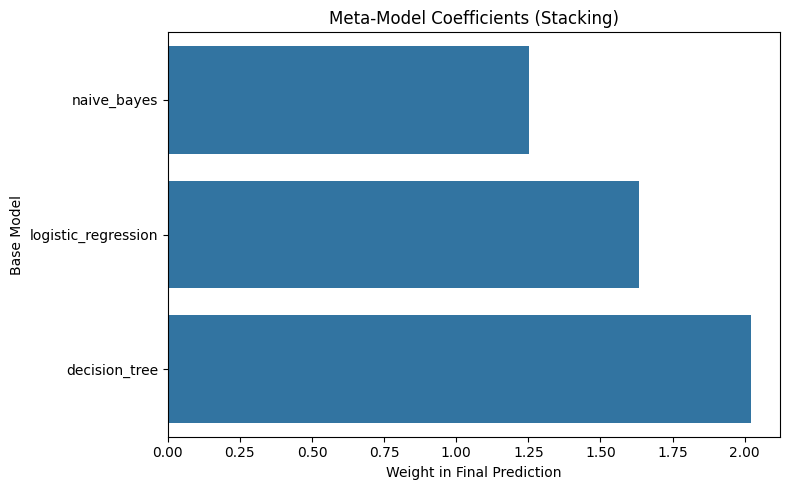

In [33]:
meta_model = stack.final_estimator_
feature_names = list(stack.named_estimators_.keys())
coefs = meta_model.coef_.flatten()

coef_df = pd.DataFrame({'Base Model': feature_names, 'Weight': coefs})
print(coef_df.sort_values(by='Weight', ascending=False))

plt.figure(figsize=(8, 5))
sns.barplot(x='Weight', y='Base Model', data=coef_df.sort_values('Weight', ascending=True))
plt.title("Meta-Model Coefficients (Stacking)")
plt.xlabel("Weight in Final Prediction")
plt.tight_layout()
plt.show()